# Tree statistics

In [1]:
import os
import sys
from collections import defaultdict
from functools import partial
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.errors import SettingWithCopyWarning
import numpy as np
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score

# from tqdm.notebook import tqdm 
from math import factorial, log, log10, log1p, floor, ceil

import multiprocess # (not the builtin multiprocessing library)

sns.set()
sns.set_style("ticks")

import tskit
import msprime

# scale down size of default plots
sns.set_context("paper")
import matplotlib as mpl
scale = 0.8
d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
d['figure.figsize'] = [5.4, 3.5]
mpl.rcParams.update(d)

In [2]:
# from scipy.special import comb
import scipy

class Comb():

    cache = {}
    
    def __init__(self):
        pass

    def __call__(self, n, k, exact=True):
        if (n, k) not in self.cache:
            self.cache[(n, k)] = scipy.special.comb(n, k, exact=exact)
        return self.cache[(n, k)]

    @classmethod
    def clear(cls):
        cls.cache = {}

    def __enter__(self):

        def init_worker(data):
            # declare scope of a new global variable
            global comb
            # store argument in the global variable for this process
            comb = data
            
        self.pool = multiprocess.Pool(processes=8, initializer=init_worker, initargs=(self,))
        return self.pool

    def __exit__(self, type, value, tb):
        self.pool.close()

Comb().clear()
comb = Comb()

with Comb() as pool:
    pass
# pool = comb.multiprocess_pool()
# pool.close()

## Combinatorial results and functions for run probabilities

In [3]:
def get_coalescence_runs(all_times, clade_times):
    clade_times_set = set(clade_times)
    k, fn = 1, 1
    coalescence_runs = []
    first_derived_coal_found = False
    for t in all_times:
        is_derived = int( t in clade_times_set)
        if first_derived_coal_found:
            coalescence_runs.append(is_derived)
        if is_derived:
            # get all the coalescences *after* the first derived one. So that the first can be both 0 and 1
            first_derived_coal_found = True
    return np.array(coalescence_runs)

def get_runs_of_1s(bits):
    for bit, group in itertools.groupby(bits):
        if bit:
            yield sum(group)

def get_all_runs(bits):
    for bit, group in itertools.groupby(bits):
        if bit:
            yield sum(group)
    bits = np.absolute(bits - 1)
    for bit, group in itertools.groupby(bits):
        if bit:
            yield sum(group)

### PDF of the number of runs of zeros and ones

If r is odd:

$\displaystyle p(r) = \frac{\binom{n_1-1}{k} \binom{n_2-1}{k-1} + \binom{n_1-1}{k-1} \binom{n_2-1}{k} }{ \binom{n_1+n_2}{n_1}}$

where $\displaystyle k = \frac{r-1}{2}$

If r is even:

$\displaystyle p(r) = \frac{2 \binom{n_1-1}{k} \binom{n_2-1}{k-1} }{ \binom{n_1+n_2}{n_1}}$

where $\displaystyle k = \frac{r}{2}$


Got it [here](http://www.statistics4u.com/fundstat_eng/ee_runs_test.html)

In [4]:
def prob_nr_of_runs(n, n1, n2):
    """
    Probability of the number runs of either zeros or ones
    n: number of runs
    n0: nr zeros
    n1: nr ones
    """
    if n % 2:
        # uneven
        k = (n - 1) //  2
        return (comb(n1-1, k)*comb(n2-1, k-1) + comb(n1-1, k-1)*comb(n2-1, k)) / comb(n1+n2, n1)
    else:
        # even
        k = n // 2
        return 2*comb(n1-1, k-1)*comb(n2-1, k-1) / comb(n1+n2, n1)    

### Probability of the longest run of ones

$P(L_n = k) = p^n \displaystyle \sum^{n-k}_{y=\lfloor n/k+1 \rfloor} (q/p)^y \sum^{y+1}_{i=1} \binom{y+1}{i}  C(n-y-ik, y+1-i, k-1)$

where

$\displaystyle C(\alpha, r, k) = \sum^r_{j=0} (-1)^j \binom{r}{j} \binom{a-(k+1)j + r - 1}{r-1} $

From equations (2) and (7) in ["Shortest and longest length of success runs in binary sequences"](https://doi:10.1016/j.jspi.2006.07.007).

0.9999799728916514


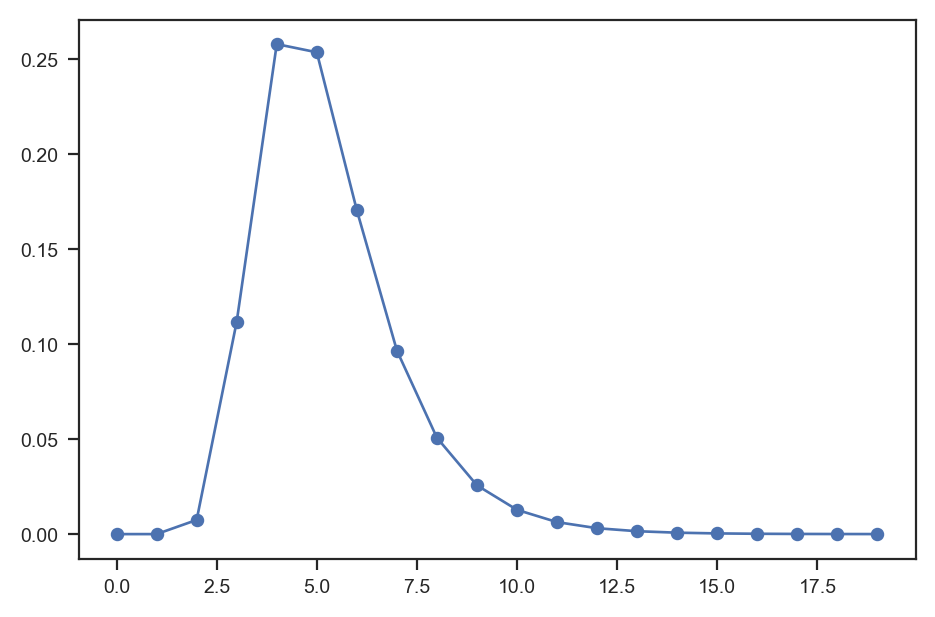

In [5]:
def prob_longest_1s_run(n, k, p):
    q = 1-p
    def C(a, r, k):
        return sum( (-1)**j * comb(r, j, exact=True) * comb(a - (k+1)*j + r - 1, r-1, exact=True) for j in range(0, r+1))
    return p**n * sum( (q/p)**y * sum( comb(y+1, i, exact=True) * C(n-y-i*k, y+1-i, k-1) for i in range(1, ((y+1)+1))) for y in range(floor(n/(k+1)), (n-k)+1) )


prob_longest_1s_run(10, 6, 0.5)

n0, n1 = 30, 30
r = 15
x = list(range(20))
y = [prob_longest_1s_run(n0+n1, r, n1/(n0+n1)) for r in x]
print(sum(y))
plt.plot(x, y, 'o-');

### Compute cached probabilities

Probability of longest run of derived:

In [6]:
import multiprocess
pool = multiprocess.Pool(processes=8)

use_cache = True
cache_file = 'prob_longest_der_run_cache.npy'

if use_cache and os.path.exists(cache_file):
    prob_longest_der_run_cache = np.load(cache_file)
else:
    n = 100
    dim = 2*n+1
    cache = np.ndarray(shape=(n+1, n+1, 2*n+1), dtype=float)
    cache[:, :, :] = np.nan
    for n0 in range(1, n+1):
        for n1 in range(1, n+1):
    
            r_list = list(range(1, n0+n1+1))
            args = list(zip([n0+n1] * len(r_list), r_list, [n1/(n0+n1)]*len(r_list)))
            for p, r in zip(pool.starmap(prob_longest_1s_run, args), r_list):
                cache[n0, n1, r] = p
            
            # for r in range(1, n0+n1+1):
            #     cache[n0, n1, r] = prob_longest_1s_run(n0+n1, r, n1/(n0+n1))
    
    pool.close()
    
    np.save(cache_file, cache)

    prob_longest_der_run_cache = cache

Proability of the number of ancestral and derived runs:

In [7]:
%%time
# import multiprocess
# pool = multiprocess.Pool(processes=8)

cache_file = 'prob_nr_of_runs_cache.npy'

if use_cache and os.path.exists(cache_file):
    prob_nr_of_runs_cache = np.load(cache_file)
else:
    n = 100
    dim = 2*n+1
    cache = np.ndarray(shape=(n+1, n+1, 2*n+1), dtype=float)
    cache[:, :, :] = np.nan
    for n0 in range(1, n+1):
        for n1 in range(1, n+1):
            for r in range(1, n0+n1):
                cache[n0, n1, r] = prob_nr_of_runs(r, n0, n1)
    
    # pool.close()
    
    np.save(cache_file, cache)

    prob_nr_of_runs_cache = cache

CPU times: user 1.34 ms, sys: 19.1 ms, total: 20.4 ms
Wall time: 44.3 ms


### Analyze data

In [8]:



def kasper_run_stat(tree_seq):
    nr_samples = tree_seq.num_samples
    
    records = []
    nodes_time = tree_seq.nodes_time
    tree_idx = 0
    for tree in tree_seq.trees():

        tree_pvalues = []
        N = tree.num_samples()
        all_times = [nodes_time[n] for n in tree.timedesc() if not tree.is_leaf(n)]
        for mut in tree.mutations():
            node = tree_seq.mutations_node[mut.id]
            clade_times = [nodes_time[n] for n in tree.timedesc(node) if not tree.is_leaf(n)]
    
            # nr-all-runs and max ones-run probabilities
            runs = get_coalescence_runs(all_times, clade_times)
    
            # if len(runs) < nr_samples / 4:
            #     continue
            
            n1 = sum(runs)
            n0 = len(runs) - n1
            run_lengths = np.fromiter(get_all_runs(runs), int)
            runs_of_1s = list(get_runs_of_1s(runs))
    
            if len(runs_of_1s) == 0:
                # trippleton or smaller
                tree_pvalues.append(np.nan)
                continue
    
            nr_runs = run_lengths.size

            if nr_runs == 1 or len(runs) <= 2 or nr_runs == len(runs):
                pvalue_nr_runs = np.nan
            else:
                try:
                    pvalue_nr_runs = prob_nr_of_runs_cache[n0, n1, 1:(nr_runs+1)].sum()
                except IndexError:
                    pvalue_nr_runs = sum(prob_nr_of_runs(x, n0, n1) for x in range(1, nr_runs+1))
    
            tree_pvalues.append(pvalue_nr_runs)


            ar = np.array(tree_pvalues)
            ar = ar[~np.isnan(ar)]
            if ar.size > 1:
                records.append(-np.log10(ar.min()))
            else:
                records.append(np.nan)
            
        
        tree_idx += 1

    return records

tree_seq = tskit.load('../data/chromhapX_tskit.trees')
pvalues = kasper_run_stat(tree_seq)

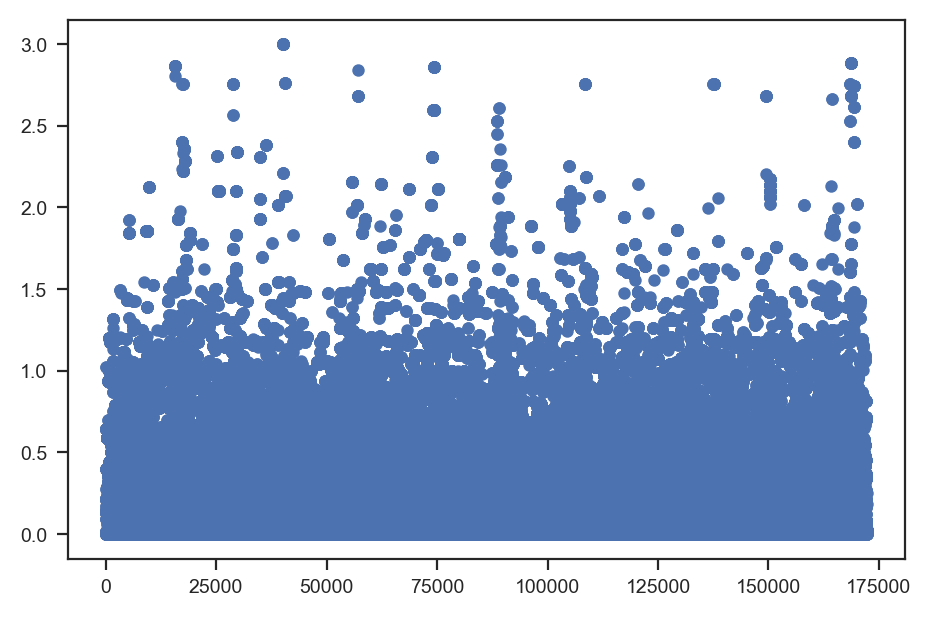

In [9]:
plt.scatter(list(range(len(pvalues))), pvalues)

## Modified Relate stat

In [10]:
def prob_descendants(s, k, fn, N):
    return comb(fn-1, s-1)*comb(N-fn-1, k-s-1)/comb(N-1, k-1)

def pos_p_val(s, k, fn, N):
    p = sum(prob_descendants(s, k, f, N) for f in range(fn, N-k+s  +1 ))
    assert 1.00000001 >= p >= 0, (p, s, k, fn, N)
    return p

def neg_p_val(s, k, fn, N):
    s, k, fn, N = k-s, k, N-fn, N
    p = sum(prob_descendants(s, k, f, N) for f in range(fn, N-k+s  +1 ))
    assert 1.00000001 >= p >= 0, (p, s, k, fn, N)
    return p


def comb_p_val(s, k, fx, kx, fn, N):
    p_value = 0
    for f1 in range(fx, kx-k+s +1):
        a = prob_descendants(s, k, f1, kx)
        for f2 in range(fn, N-k+s  +1 ):
            b = prob_descendants(kx-fx, kx, N-f2, N)
            p_value += a * b
    return p_value


def get_intermediate_states(all_times, clade_times):
    clade_times_set = set(clade_times)
    k, fn = 1, 1
    intermediate_states = []
    for t in all_times:
        k += 1
        if t in clade_times_set:
            fn += 1
            if fn >= 2:
                intermediate_states.append((fn, k))
    return intermediate_states

def get_comb_pvalues(k, fn, N, intermediate_states):
    p_values = []
    for i, (fx, kx) in enumerate(intermediate_states):
        pos_p = pos_p_val(2, k, fx, kx)
        assert kx <= N, (kx, N)
        neg_p = neg_p_val(fx, kx, fn, N)
        # p_values.append((pos_p, neg_p))
        comb_p = comb_p_val(2, k, fx, kx, fn, N)
        p_values.append((pos_p, neg_p, comb_p))
    return p_values

### Analyze data

In [11]:

def sim_tree_sequence(nr_samples, L=1_000_000, rho=1e-8, mu=1e-8, 
                      # n_subpops=1, 
                      # subpop_size=3e4, 
                      # migration_rate=1e-4
                     ):

    demography = msprime.Demography()
    demography.add_population(name="pop_1", initial_size=30000)
    samples={'pop_1': nr_samples}
    
    ts_no_mut = msprime.sim_ancestry(
        samples=nr_samples,
        demography=demography,
        # samples={f"pop_{i}": 100 for i in range(n_subpops)},  # 10 samples from each subpop
        # demography=msprime.Demography.island_model([subpop_size] * n_subpops, migration_rate),
        ploidy=1,
        recombination_rate=rho,
        sequence_length=L,
        # random_seed=123,
    )
    ts_mutated = msprime.sim_mutations(ts_no_mut, rate=mu, 
                                       # random_seed=456
                                      )
    return ts_mutated


def kasper_comb_stat(tree_seq):

    with Comb() as pool:

    # for treeseq_file_name in ['../data/chromhapX_tskit.trees',
    #                           '../data/Mikumi_relate_chromhapX.trees',
    #                           '../data/Tanzania_Olive_relate_chromhapX.trees',
    #                           '../data/Eastern_Yellow_relate_chromhapX.trees'
    #                          ]:
        # print(treeseq_file_name)
        
        # output_file_name = modpath(treeseq_file_name, parent='../results', suffix='.h5')
        
        # tree_seq = tskit.load(treeseq_file_name)
        
    
    
        nr_samples = tree_seq.num_samples
        
    
        
        # tree_seq = sim_tree_sequence()
        # tree_seq
    
        ####################################################################
    
        def fun(_):
    
            pos_data = defaultdict(list)
            neg_data = defaultdict(list)
            comb_data = defaultdict(list)
            
            sim_tree_seq = sim_tree_sequence(nr_samples)
            nodes_time = sim_tree_seq.nodes_time
            for tree_idx, tree in enumerate(sim_tree_seq.trees()):
                N = tree.num_samples()
                all_times = [nodes_time[n] for n in tree.timedesc() if not tree.is_leaf(n)]
                p_values = []
                for mut in tree.mutations():
                    node = sim_tree_seq.mutations_node[mut.id]
                    
                    clade_times = [nodes_time[n] for n in tree.timedesc(node) if not tree.is_leaf(n)]
                    intermediate_states = get_intermediate_states(all_times, clade_times)
                            
                    if len(intermediate_states) <= 2:
                        continue            
                    two, k = intermediate_states.pop(0)
                    assert two == 2
                    fn, N = intermediate_states[-1]
                    p_values = get_comb_pvalues(k, fn, N, intermediate_states)
    
                if p_values:
                    # pos_p_values, neg_p_values, comb_p_values = zip(*p_values)
                    pos_p_values, neg_p_values, comb_p_values = zip(*p_values)
                    pos_data[k].append(pos_p_values)
                    neg_data[k].append(neg_p_values)
                    comb_data[k].append(comb_p_values)
            return pos_data, neg_data, comb_data
    
    
        pos_data = defaultdict(list)
        neg_data = defaultdict(list)
        comb_data = defaultdict(list)    

        # for data in pool.imap(fun, list(range(100))):
        for data in map(fun, range(100)):        
            
            _pos_data, _neg_data, _comb_data = data
            
            for key in _pos_data:
                pos_data[key].extend(_pos_data[key])
            for key in _neg_data:
                neg_data[key].extend(_neg_data[key])                
            for key in _comb_data:
                comb_data[key].extend(_comb_data[key])
        
        #samples = tree_seq.num_samples
        pos_corrections = {}
        neg_corrections = {}
        comb_corrections = {}
        
        bins = np.linspace(0, 1, 1000)    # CHANGE BACK TO 1000
        for k in range(3, nr_samples):
            c = 1
            for i in range(nr_samples-k):
                a, b = [], []
                for x in pos_data[k]:
                    if len(x) > i+1:
                        a.append(x[i])
                        b.append(x[i+1])
                # c += 1 - normalized_mutual_info_score(np.digitize(a, bins), np.digitize(b, bins))
                c += 1 - adjusted_mutual_info_score(np.digitize(a, bins), np.digitize(b, bins))                
                # print('pos', k, i, c)
                pos_corrections[(k, i+1)] = c    
            
        
            c = 1
            for i in range(nr_samples-k):
                a, b = [], []
                for x in neg_data[k]:
                    if len(x) > i+1:
                        a.append(x[i])
                        b.append(x[i+1])
                # c += 1 - normalized_mutual_info_score(np.digitize(a, bins), np.digitize(b, bins))
                c += 1 - adjusted_mutual_info_score(np.digitize(a, bins), np.digitize(b, bins))
                # print('neg', k, i, c)
                neg_corrections[(k, i+1)] = c
        
            c = 1
            for i in range(nr_samples-k):
                a, b = [], []
                for x in comb_data[k]:
                    if len(x) > i+1:
                        a.append(x[i])
                        b.append(x[i+1])
                # c += 1 - normalized_mutual_info_score(np.digitize(a, bins), np.digitize(b, bins))
                c += 1 - adjusted_mutual_info_score(np.digitize(a, bins), np.digitize(b, bins))                
                # print('comb', k, i, c)
                comb_corrections[(k, i+1)] = c
    
        
    
        
        records = []
        nodes_time = tree_seq.nodes_time
        tree_idx = 0
        for tree in tree_seq.trees():

            tree_pvalues = []
            N = tree.num_samples()
            all_times = [nodes_time[n] for n in tree.timedesc() if not tree.is_leaf(n)]
            for mut in tree.mutations():
                node = tree_seq.mutations_node[mut.id]
                clade_times = [nodes_time[n] for n in tree.timedesc(node) if not tree.is_leaf(n)]
    
                # modified relate stat
                
                intermediate_states = get_intermediate_states(all_times, clade_times)
        
                if len(intermediate_states) < 4:
                    tree_pvalues.append(np.nan)
                    continue
                    
                two, k = intermediate_states.pop(0)
                assert two == 2
                if k == 2:
                    tree_pvalues.append(np.nan)
                    continue
        
                # fn, N = intermediate_states[-1]
                fn, N = intermediate_states.pop() # TODO: check this is correct
        
                if fn / N < 0.2:
                    continue
        
                p_values = get_comb_pvalues(k, fn, N, intermediate_states)
                nr_inter = len(intermediate_states)
                
                interval = tree.interval
                num_mutations = tree.num_mutations
        
    
                clade_left, clade_right = interval.left, interval.right
                
                
                p_p, n_p, c_p = zip(*p_values)
        
                idx = p_p.index(min(p_p))
                # records.append(['pos',
                #                 mut.site, 
                #                 max(0.0, -log10((p_values[idx][0])*pos_corrections[(k, nr_inter)])), 
                #                 clade_times[0], 
                #                 clade_times[idx],
                #                 two,
                #                 k,
                #                 intermediate_states[idx][0],
                #                 intermediate_states[idx][1],
                #                 fn,
                #                 N,
                #                 interval.left,
                #                 interval.right,
                #                 clade_left, 
                #                 clade_right,
                #                 num_mutations, 
                #                 node])
                # idx = n_p.index(min(n_p))
                # records.append(['neg',
                #                 mut.site, 
                #                 max(0.0, -log10((p_values[idx][1])*neg_corrections[(k, nr_inter)])), 
                #                 clade_times[0], 
                #                 clade_times[idx],
                #                 two,
                #                 k,
                #                 intermediate_states[idx][0],
                #                 intermediate_states[idx][1],
                #                 fn,
                #                 N,
                #                 interval.left,
                #                 interval.right,
                #                 clade_left, 
                #                 clade_right,
                #                 num_mutations, 
                #                 node])
                # c_idx = c_p.index(min(c_p))        
                # records.append(['comb',
                #                 mut.site, 
                #                 max(0.0, -log10((p_values[idx][2])*comb_corrections[(k, nr_inter)])), 
                #                 clade_times[0], 
                #                 clade_times[idx],
                #                 two,
                #                 k,
                #                 intermediate_states[idx][0],
                #                 intermediate_states[idx][1],
                #                 fn,
                #                 N,
                #                 interval.left,
                #                 interval.right,
                #                 clade_left, 
                #                 clade_right,
                #                 num_mutations, 
                #                 node])        

                tree_pvalues.append(max(0.0, -log10((p_values[idx][2])*comb_corrections[(k, nr_inter)])))
            
            ar = np.array(tree_pvalues)
            ar = ar[~np.isnan(ar)]
            if ar.size > 1:
                records.append(ar.min())
            else:
                records.append(np.nan)

            tree_idx += 1        

    return records

        
tree_seq = tskit.load('../data/chromhapX_tskit.trees')
pvalues = kasper_comb_stat(tree_seq)
     
    

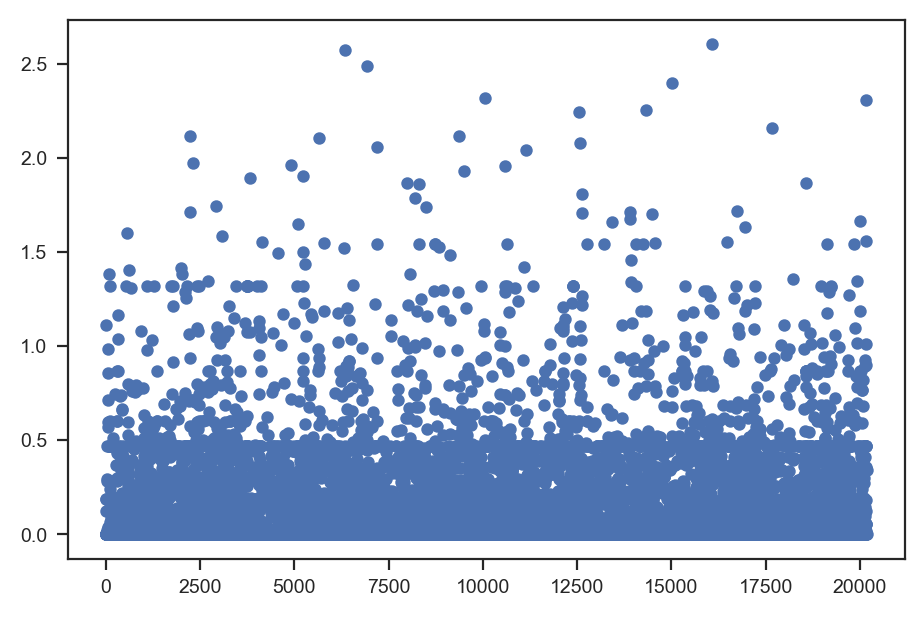

In [13]:
plt.scatter(list(range(len(pvalues))), pvalues)

In [1]:
from kasper_stats import kasper_run_stat, kasper_comb_stat

In [3]:
import tskit

tree_seq = tskit.load('../data/chromhapX_tskit.trees')
run_stat_logp = kasper_run_stat(tree_seq)

In [4]:
tree_seq = tskit.load('../data/chromhapX_tskit.trees')
comb_stat_logp = kasper_comb_stat(tree_seq)

In [5]:
! pwd

/Users/kmt/google_drive/projects/tree-stats/notebooks
